In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import interpolate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def integral(Y1,Y2,E1,E2):
    INT=(Y2*E2-Y1*E1)/((np.log(Y2/Y1)/np.log(E2/E1)+1))
    #print(E1,E2,INT)
    return INT

def load_obj(name):
    with open('C:\\Users\\ginti\\Desktop\\nirs\\' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def Y_NM_Mi20_a(energy,h):
    P=np.sqrt(energy*energy+2*0.938*energy)
    X=np.log(P)
    if energy<1.7:
        a,b,c,d=0.5082, -3.0659, 7.2827, -9.5396
    #if energy<1.6:
    #    a,b,c,d=2.0404,	-8.1776,	12.354,	-11.1
    elif (energy>=1.7 and energy<15):
        a,b,c,d=0.1179,	-1.2022,	4.9329,	-8.65
    else:
        a,b,c,d=0,	-0.0365,	1.206,	-4.763
    LnY1000=a*X*X*X+b*X*X+c*X+d
    Y1000=np.exp(LnY1000)
    A = 9.422E-09*np.power(X,5) - 2.284E-07*np.power(X,4) + 2.037E-06*np.power(X,3) - 7.828E-06*np.power(X,2) + 1.203E-05*np.power(X,1) - 5.545E-06					
    B = -5.351E-06*np.power(X,5) + 1.316E-04*np.power(X,4) - 1.226E-03*np.power(X,3) + 5.176E-03*np.power(X,2) - 1.017E-02*np.power(X,1) + 1.458E-02				
    alt_dep=(1000-h)*(1000-h)*A+(1000-h)*B
    Y=Y1000*np.exp(alt_dep)
    return Y

def Y_NM_Mi20_p(energy, h):
    P=np.sqrt(energy*energy+2*0.938*energy)
    X=np.log(P)
    #if energy<1.25:
    #    a,b,c,d=6.09,	-14.06,	13.98,	-11.615
    if energy<1.28:
        a,b,c,d=0,	-8.6616,	13.879,	-12.104
    elif energy >=1.28 and energy<10:
        a,b,c,d=-0.186,	0.428,	2.831,	-8.76
    else:
        a,b,c,d=0,	-0.0365,	1.206,	-4.763
    LnY1000=a*X*X*X+b*X*X+c*X+d
    Y1000=np.exp(LnY1000)
    A= 6.945E-09*np.power(X,5) - 1.461E-07*np.power(X,4) + 1.115E-06*np.power(X,3) - 3.402E-06*np.power(X,2) + 3.355E-06*np.power(X,1) - 9.823E-07
    B= -3.963E-06*np.power(X,5) + 8.091E-05*np.power(X,4) - 6.394E-04*np.power(X,3) + 2.348E-03*np.power(X,2) - 4.713E-03*np.power(X,1) + 1.186E-02
    alt_dep=(1000-h)*(1000-h)*A+(1000-h)*B
    Y=Y1000*np.exp(alt_dep)
    return Y

In [10]:
def hepams(ener):
    
    data_protons = load_obj('AMS_spec_p')
    data_he = load_obj('AMS_spec_he')

    newprot = []

    for k in data_protons:
        x = np.log10(data_protons[k][0])
        y = np.log10(data_protons[k][2])
        f = interpolate.interp1d(x, y, fill_value="extrapolate")

        xnew = np.log10(data_he[k][0])
        ynew=f(xnew)

        newprot.append(10**ynew)
    
    iheavy = open('C:\\Users\\ginti\\Desktop\\nirs\\heavy.txt','r')
    linesiheavy = iheavy.readlines()
    heavy = []
    for x in linesiheavy:
        heavy.append(x.split()[1])
    iheavy.close()

    l = 0
    hep = []
    meh = []

    for i in data_he:
        a = (float(data_he[i].iloc[[ener], [2]].values)*(1 + float(heavy[ener])))/float(newprot[l][ener])
        hep.append(a)                
        l+=1
        
    return hep

In [11]:
def summ1(pc,depth):
    
    tt = depth
    
    data_protons = load_obj('AMS_spec_p')
    data_he = load_obj('AMS_spec_he')
    
    al = []
    s1 = 0
    
    for j in data_protons:
        for k in range(0,71):
            if float(data_protons[j].iloc[[k], [0]].values) > pc:            
                a = float(data_protons[j].iloc[[k], [4]].values)
                b = Y_NM_Mi20_p(a,tt) * float(data_protons[j].iloc[[k], [6]].values)
                c = float(data_protons[j].iloc[[k+1], [4]].values)
                d = Y_NM_Mi20_p(c,tt) * float(data_protons[j].iloc[[k+1], [6]].values)
                s1 += integral(b, d, a, c)
        al.append(s1)
        s1 = 0
        
    s2 = 0
    an = []
    
    iheavy = open('C:\\Users\\ginti\\Desktop\\nirs\\heavy.txt','r')
    linesiheavy = iheavy.readlines()
    heavy = []
    for x in linesiheavy:
        heavy.append(x.split()[1])
    iheavy.close()
    
    for j in data_he:
        for k in range(0,66):        
            if float(data_he[j].iloc[[k], [0]].values) > pc:
                a = float(data_he[j].iloc[[k], [4]].values)
                b = Y_NM_Mi20_a(a,tt) * float(data_he[j].iloc[[k], [6]].values) * (1 + float(heavy[k]))
                c = float(data_he[j].iloc[[k+1], [4]].values)
                d = Y_NM_Mi20_a(c,tt) * float(data_he[j].iloc[[k+1], [6]].values)  * (1 + float(heavy[k]))
                s2 += integral(b, d, a, c)
        an.append(4*s2)
        s2 = 0
    nn = []
    
    for i in range(len(an)):
        phe = al[i] + an[i]
        nn.append(phe)
        
    return nn

In [12]:
n57 = summ1(6.90668,886.94)
nn57 = []
for i in n57:
    nn57.append(i/(sum(n57)/len(n57)))
n010 = summ1(0,1025.07)
nn010 = []
for i in n010:
    nn010.append(i/(sum(n010)/len(n010)))
    
time = load_obj('AMS_time')
t = []
for j in range(0, 79):
    a = float(time.iloc[[j], [0]].values)
    t.append(a)

Text(0, 0.5, '$NM_{1}/NM_{2}$')

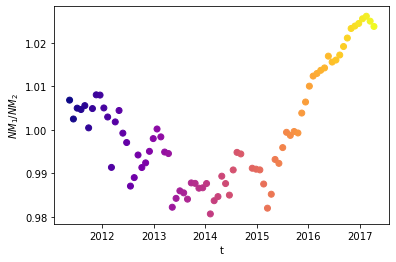

In [13]:
nnn=[]
for i in range(len(n57)):
    a=nn010[i]/nn57[i]
    nnn.append(a)
    
fig = plt.figure()
plt.scatter(t, nnn, c=t, cmap="plasma")
plt.xlabel('t')
plt.ylabel('$NM_{1}/NM_{2}$')

In [14]:
data_he = load_obj('AMS_spec_he')

In [15]:
hepa = []
for k in range(len(data_he[2426])):
    he = hepams(k)
    hepa.append(he)

In [18]:
hepa

[[0.1630562218805632,
  0.16644015732647813,
  0.16642680455696204,
  0.16698578970538433,
  0.16597084700368267,
  0.16432326000000008,
  0.1663834486219803,
  0.1649855660192591,
  0.16845896253649048,
  0.16922906497461923,
  0.1665745534450009,
  0.1646549888337469,
  0.16610844997266264,
  0.16386045175976194,
  0.16598176763875827,
  0.16368664124783372,
  0.16340615587044535,
  0.16284410051259196,
  0.16372820480404549,
  0.16574543290522584,
  0.16804061377961307,
  0.1655408011002962,
  0.16536943485243932,
  0.16626723200627586,
  0.16412334336283183,
  0.16600923219878888,
  0.16509910383653037,
  0.1626336406754408,
  0.16474444792188286,
  0.16477367581602367,
  0.16259788530642383,
  0.16353049417249416,
  0.1627115475113123,
  0.16371444798994983,
  0.16585505139350556,
  0.1629404081157922,
  0.16495134396355357,
  0.16541070345963751,
  0.16318775139442232,
  0.16572493176470593,
  0.16361425359317908,
  0.16594014817572605,
  0.1653318703703703,
  0.1656144803875236,

In [16]:
corr = []
for k in hepa:
    x = np.array(k).reshape((-1, 1))
    y = np.array(nnn)
    model = LinearRegression().fit(x, y)

    x_train = x.reshape(-1, 1)
    x_test = x.reshape(-1, 1)
    y_pred = model.predict(x_test)
    coefficient_of_dermination2 = r2_score(y, y_pred)
    corr.append(coefficient_of_dermination2)

print(corr)

[0.7227132692252348, 0.7776223193904162, 0.7566775247754638, 0.6008815622044066, 0.4261026627957303, 0.21151122368455721, 0.28377330933609, 0.0864196902761275, 0.005550455211678629, 0.016845547619629975, 0.01391725750438122, 0.036913770894670295, 0.012141442388316381, 0.06340976589483527, 0.012689677391623522, 0.00029623564970193694, 0.00030044771744142107, 0.005065285707737122, 0.0010394131532598383, 0.009595457006184138, 0.001830813909447282, 0.010486163246039348, 0.005541535810338782, 0.0026764393079421467, 2.5451141194565707e-10, 0.031177497437782087, 0.00032493047549586596, 0.06150524216165176, 0.0007061092994073981, 0.019823206048378283, 0.0035524463572893517, 0.0034056758391589614, 0.025439101986319157, 9.89394481232253e-07, 0.006522783809890242, 0.03093993141922957, 0.017067914402230433, 0.00876437851235623, 0.05692223901032034, 0.001362154383946601, 0.0, 1.1102230246251565e-16, 0.0, 0.0, 1.1102230246251565e-16, 0.0, 0.0, 0.0, 1.1102230246251565e-16, 0.0, 0.0, 1.110223024625156

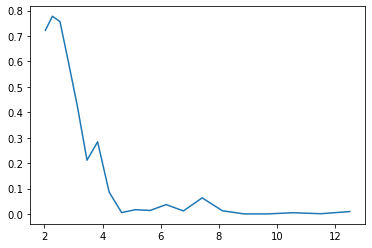

In [17]:
ener = data_he[2426][0]

fig, ax = plt.subplots()
ax.plot(ener[:20], corr[:20])